'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


RuntimeError: Requested MovieWriter (ffmpeg) not available

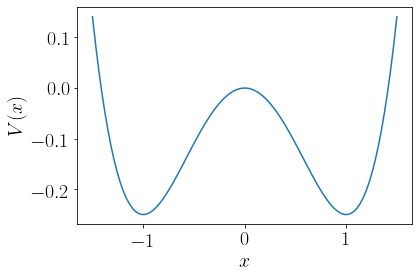

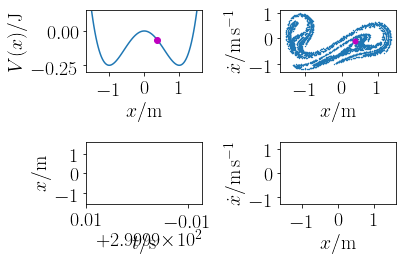

In [1]:
import numpy as np
from scipy.integrate import odeint, quad
from scipy.optimize import brentq
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sbs
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 20})
rc('text', usetex=True)
rc('animation', html='html5')

# The potential and its first derivative, as callables.
V = lambda x: 0.5 * x**2 * (0.5 * x**2 - 1)
dVdx = lambda x: x**3 - x

# The potential energy function on a grid of x-points.
xgrid = np.linspace(-1.5, 1.5, 100)
Vgrid = V(xgrid)

plt.plot(xgrid, Vgrid)
plt.xlabel('$x$')
plt.ylabel('$V(x)$')

def deriv(X, t, gamma, delta, omega):
    """Return the derivatives dx/dt and d2x/dt2."""

    x, xdot = X
    xdotdot = -dVdx(x) -delta * xdot + gamma * np.cos(omega*t)
    return xdot, xdotdot

def solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega):
    """Solve the Duffing equation for parameters gamma, delta, omega.

    Find the numerical solution to the Duffing equation using a suitable
    time grid: tmax is the maximum time (s) to integrate to; t_trans is
    the initial time period of transient behaviour until the solution
    settles down (if it does) to some kind of periodic motion (these data
    points are dropped) and dt_per_period is the number of time samples
    (of duration dt) to include per period of the driving motion (frequency
    omega).

    Returns the time grid, t (after t_trans), position, x, and velocity,
    xdot, dt, and step, the number of array points per period of the driving
    motion.

    """
    # Time point spacings and the time grid

    period = 2*np.pi/omega
    dt = 2*np.pi/omega / dt_per_period
    step = int(period / dt)
    t = np.arange(0, tmax, dt)
    # Initial conditions: x, xdot
    X0 = [x0, v0]
    X = odeint(deriv, X0, t, args=(gamma, delta, omega))
    idx = int(t_trans / dt)
    return t[idx:], X[idx:], dt, step

# Set up the motion for a oscillator with initial position
# x0 and initially at rest.
x0, v0 = 0, 0
tmax, t_trans = 18000, 300
omega = 1.4
gamma, delta = 0.39, 0.1
dt_per_period = 100

# Solve the equation of motion.
t, X, dt, pstep = solve_duffing(tmax, dt_per_period, t_trans, x0, v0, gamma, delta, omega)
x, xdot = X.T

# The animation
fig, ax = plt.subplots(nrows=2,ncols=2)
ax1 = ax[0,0]
ax1.plot(xgrid, Vgrid)
ax1.set_ylim(-0.3, 0.15)
ln1, = ax1.plot([], [], 'mo')
ax1.set_xlabel(r'$x / \mathrm{m}$')
ax1.set_ylabel(r'$V(x) / \mathrm{J}$')

# Position as a function of time
ax2 = ax[1,0]
ax2.set_xlabel(r'$t / \mathrm{s}$')
ax2.set_ylabel(r'$x / \mathrm{m}$')
ln2, = ax2.plot(t[:100], x[:100])
ax2.set_ylim(np.min(x), np.max(x))

# Phase space plot
ax3 = ax[1,1]
ax3.set_xlabel(r'$x / \mathrm{m}$')
ax3.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ln3, = ax3.plot([], [])
ax3.set_xlim(np.min(x), np.max(x))
ax3.set_ylim(np.min(xdot), np.max(xdot))

# Poincaré section plot
ax4 = ax[0,1]
ax4.set_xlabel(r'$x / \mathrm{m}$')
ax4.set_ylabel(r'$\dot{x} / \mathrm{m\,s^{-1}}$')
ax4.scatter(x[::pstep], xdot[::pstep], s=2, lw=0, c=sbs.color_palette()[0])
scat1 = ax4.scatter([x0], [v0], lw=0, c='m')
plt.tight_layout()

def animate(i):
    """Update the image for iteration i of the Matplotlib animation."""

    ln1.set_data(x[i], V(x[i]))
    ln2.set_data(t[:i+1], x[:i+1])
    ax2.set_xlim(t_trans, t[i])
    ln3.set_data(x[:i+1], xdot[:i+1])
    if not i % pstep:
        scat1.set_offsets(X[i])
    return

anim = animation.FuncAnimation(fig, animate, frames=len(x), interval=1)

Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

anim.save('duffing.mp4', writer=writer)